In [3]:
import pandas as pd
import numpy as np
from pathlib import Path

from src.models.buffered_cv import BufferedBlockedSplit

In [4]:
data_path = Path('../data/processed/cup_10_min_aggs.parquet')
assert data_path.exists()

In [5]:
met = pd.read_parquet(data_path)
met.head(3)

Air_Temp_87m                                             \
                           count        max       mean        min       var   
timestamp                                                                     
2018-12-31 17:00:00          600 -15.477113 -15.691004 -15.805410  0.002746   
2018-12-31 17:10:00          600 -15.577877 -15.798286 -15.977685  0.004473   
2018-12-31 17:20:00          600 -15.714396 -16.011219 -16.208467  0.008372   

                    Cup_WS_C1_105m                                         \
                           3s_gust count integrated_low_freq_ke       max   
timestamp                                                                   
2018-12-31 17:00:00       8.805074   600               0.212934  8.917205   
2018-12-31 17:10:00       8.546263   600               0.368811  8.775206   
2018-12-31 17:20:00       8.774642   600               0.196161  8.879639   

                               ... Vane_WD_122m                        \
                         mean  ...        count        max       mean   
timestamp                      ...                                      
2018-12-31 17:00:00  7.490526  ...          600  33.494221  22.310926   
2018-12-31 17:10:00  7.050964  ...          600  31.750303  18.813911   
2018-12-31 17:20:00  7.794179  ...          600  33.310650  18.989834   

                                          Vane_WD_87m                        \
                           min        var       count        max       mean   
timestamp                                                                     
2018-12-31 17:00:00  11.305159  15.657919         600  36.993736  23.034079   
2018-12-31 17:10:00   3.709938  23.281769         600  34.089355  21.583694   
2018-12-31 17:20:00   5.362070  25.907095         600  35.241886  20.046831   

                                           
                           min        var  
timestamp                                  
2018-12-31 17:00:00  10.439404  17.228054  
2018-12-31 17:10:00   3.040152  25.558174  
2018-12-31 17:20:00   2.509987  19.110186  

[3 rows x 34 columns]

In [8]:
met.head(1).T

timestamp                              2018-12-31 17:00:00
Air_Temp_87m   count                            600.000000
               max                              -15.477113
               mean                             -15.691004
               min                              -15.805410
               var                                0.002746
Cup_WS_C1_105m 3s_gust                            8.805074
               count                            600.000000
               integrated_low_freq_ke             0.212934
               max                                8.917205
               mean                               7.490526
               min                                5.818164
               var                                0.288631
Cup_WS_C1_130m 3s_gust                            8.685490
               count                            600.000000
               integrated_low_freq_ke             0.195348
               max                                9.123878
               mean                               7.629745
               min                                6.183786
               var                                0.257707
DeltaT_122_87m count                            600.000000
               max                               -0.274433
               mean                              -0.304441
               min                               -0.330359
               var                                0.000068
Vane_WD_122m   count                            600.000000
               max                               33.494221
               mean                              22.310926
               min                               11.305159
               var                               15.657919
Vane_WD_87m    count                            600.000000
               max                               36.993736
               mean                              23.034079
               min                               10.439404
               var                               17.228054

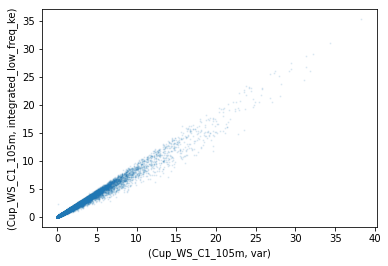

In [7]:
met.plot.scatter(('Cup_WS_C1_105m', 'var'), ('Cup_WS_C1_105m', 'integrated_low_freq_ke'), alpha=0.1, s=1)

From the plot above, linear regression is an obvious choice of baseline model. But first I'll do some feature engineering.
# Feature engineering
Domain specific features:
* wind shear
* bulk richardson number
* monin-obukhov length
* temperature lapse rate (gradient)
* direction veer rate

# Baseline - linear regression

In [ ]:
from sklearn.linear_model import LinearRegression

